# Question/Answering system over SQL data

Documentation: https://python.langchain.com/docs/tutorials/sql_qa/

Security best practices: https://python.langchain.com/docs/security/

Agents: 
- https://python.langchain.com/docs/concepts/agents/
- https://langchain-ai.github.io/langgraph/concepts/agentic_concepts/?_gl=1*tol24f*_ga*MTM1ODM1Njc2NC4xNzQ5NDg1ODQ5*_ga_47WX3HKKY2*czE3NDk2MzYzNzgkbzMkZzEkdDE3NDk2MzY2NDgkajYwJGwwJGgw
- https://langchain-ai.github.io/langgraph/reference/agents/#langgraph.prebuilt.chat_agent_executor.create_react_agent


Add persistance (memory) 
- https://langchain-ai.github.io/langgraph/how-tos/persistence/#add-short-term-memory
- https://langchain-ai.github.io/langgraph/how-tos/persistence/


Human In the loop: 
- https://langchain-ai.github.io/langgraph/concepts/human_in_the_loop/

Database: 
- [file](../Data/Chinook_PostgreSql.sql)
- https://github.com/lerocha/chinook-database?tab=readme-ov-file
- brew install pgloader


In [3]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")
print(db.dialect)
print(db.get_usable_table_names())
db.run("SELECT * FROM Artist LIMIT 10;")

sqlite
['album', 'artist', 'customer', 'employee', 'invoice']


"[('1', 'AC/DC'), ('2', 'Accept'), ('3', 'Aerosmith'), ('4', 'Alanis Morissette'), ('5', 'Alice In Chains'), ('6', 'Antônio Carlos Jobim'), ('7', 'Apocalyptica'), ('8', 'Audioslave'), ('9', 'BackBeat'), ('10', 'Billy Cobham')]"

## Chains

Chains are compositions of predictable steps. In LangGraph, we can represent a chain via simple sequence of nodes. 

- converts the question into a SQL query;
- executes the query;
- uses the result to answer the original question.

In [4]:
from typing_extensions import TypedDict


class State(TypedDict):
    question: str
    query: str
    result: str
    answer: str

In [6]:
from langchain.chat_models import init_chat_model


llm = init_chat_model(
    model="llama3.2"
    ,model_provider="ollama"
)

In [7]:
from langchain_core.prompts import ChatPromptTemplate

system_message = """
Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}
"""

user_prompt = "Question: {input}"

query_prompt_template = ChatPromptTemplate(
    [("system", system_message), ("user", user_prompt)]
)

for message in query_prompt_template.messages:
    message.pretty_print()

================================ System Message ================================


Given an input question, create a syntactically correct {dialect} query to
run to help find the answer. Unless the user specifies in his question a
specific number of examples they wish to obtain, always limit your query to
at most {top_k} results. You can order the results by a relevant column to
return the most interesting examples in the database.

Never query for all the columns from a specific table, only ask for a the
few relevant columns given the question.

Pay attention to use only the column names that you can see in the schema
description. Be careful to not query for columns that do not exist. Also,
pay attention to which column is in which table.

Only use the following tables:
{table_info}

================================ Human Message =================================

Question: {input}


In [24]:
print(db.get_table_info())


CREATE TABLE album (
	album_id TEXT, 
	title TEXT, 
	artist_id TEXT
)

/*
3 rows from album table:
album_id	title	artist_id
1	For Those About To Rock We Salute You	1
2	Balls to the Wall	2
3	Restless and Wild	2
*/


CREATE TABLE artist (
	artist_id TEXT, 
	name TEXT
)

/*
3 rows from artist table:
artist_id	name
1	AC/DC
2	Accept
3	Aerosmith
*/


CREATE TABLE customer (
	customer_id TEXT, 
	first_name TEXT, 
	last_name TEXT, 
	company TEXT, 
	address TEXT, 
	city TEXT, 
	state TEXT, 
	country TEXT, 
	postal_code TEXT, 
	phone TEXT, 
	fax TEXT, 
	email TEXT, 
	support_rep_id TEXT
)

/*
3 rows from customer table:
customer_id	first_name	last_name	company	address	city	state	country	postal_code	phone	fax	email	support_rep_id
1	Luís	Gonçalves	Embraer - Empresa Brasileira de Aeronáutica S.A.	Av. Brigadeiro Faria Lima, 2170	São José dos Campos	SP	Brazil	12227-000	+55 (12) 3923-5555	+55 (12) 3923-5566	luisg@embraer.com.br	3
2	Leonie	Köhler	None	Theodor-Heuss-Straße 34	Stuttgart	None	Germany	701

In [30]:
print(db.dialect)

sqlite


In [8]:
from typing_extensions import Annotated


class QueryOutput(TypedDict):
    """Generated SQL query."""

    query: Annotated[str, ..., "Syntactically valid SQL query."]


def write_query(state: State):
    """Generate SQL query to fetch information."""
    prompt = query_prompt_template.invoke(
        {
            "dialect": db.dialect,
            "top_k": 10,
            "table_info": db.get_table_info(),
            "input": state["question"],
        }
    )
    structured_llm = llm.with_structured_output(QueryOutput)
    result = structured_llm.invoke(prompt)
    return {"query": result["query"]}

In [10]:
write_query({"question": "How many Employees are there?"})

{'query': 'SELECT COUNT(*) FROM album LIMIT 10'}

In [16]:
write_query({"question": "What are the Ids of the employees?"})

{'query': 'SELECT employee_id FROM employee LIMIT 10 ORDER BY title DESC'}

### Query execution 

In [14]:
from langchain_community.tools.sql_database.tool import QuerySQLDatabaseTool


def execute_query(state: State):
    """Execute SQL query."""
    execute_query_tool = QuerySQLDatabaseTool(db=db)
    return {"result": execute_query_tool.invoke(state["query"])}

In [17]:
execute_query({"query": "SELECT COUNT(employee_id) AS EmployeeCount FROM Employee;"})

{'result': '[(8,)]'}

In [18]:
def generate_answer(state: State):
    """Answer question using retrieved information as context."""
    prompt = (
        "Given the following user question, corresponding SQL query, "
        "and SQL result, answer the user question.\n\n"
        f'Question: {state["question"]}\n'
        f'SQL Query: {state["query"]}\n'
        f'SQL Result: {state["result"]}'
    )
    response = llm.invoke(prompt)
    return {"answer": response.content}

In [19]:
from langgraph.graph import START, StateGraph

graph_builder = StateGraph(State).add_sequence(
    [write_query, execute_query, generate_answer]
)
graph_builder.add_edge(START, "write_query")
graph = graph_builder.compile()

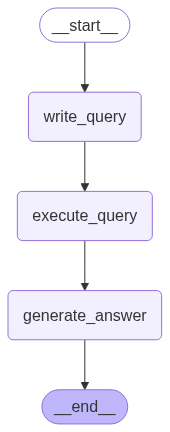

In [20]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
for step in graph.stream(
    {"question": "How many employees are there?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT COUNT(*) FROM employee LIMIT 10'}}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': 'Based on the provided information, the answer to the user question "How many employees are there?" is that there are 8 employees. \n\nThe SQL query `SELECT COUNT(*) FROM employee LIMIT 10` was used to retrieve this count, but it\'s worth noting that the `LIMIT 10` clause in the query is likely a mistake or an error, as it would return only the first 10 employees from the result set, rather than the total number of employees. \n\nThe actual result, `[(8,)]`, indicates that there are indeed 8 employees in the database, but the SQL query used to retrieve this count contained an error.'}}


In [22]:
for step in graph.stream(
    {"question": "How many employees have the title of Sales Support Agent?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': "SELECT COUNT(*) FROM employee WHERE title = 'Sales Support Agent'"}}
{'execute_query': {'result': '[(3,)]'}}
{'generate_answer': {'answer': 'According to the SQL result, there are 3 employees who have the title of "Sales Support Agent".'}}


In [23]:
for step in graph.stream(
    {"question": "How old is the oldest employee?"}, stream_mode="updates"
):
    print(step)

{'write_query': {'query': 'SELECT MAX(T1.birth_date) AS age FROM employee AS T1 LEFT JOIN employee AS T2 ON T1.reports_to = T2.employee_id WHERE T2.employee_id IS NULL'}}
{'execute_query': {'result': "[('1962-02-18 00:00:00',)]"}}
{'generate_answer': {'answer': 'The oldest employee is the one born on February 18, 1962.'}}


## Human-in-the-loop

can interrupt our application before sensitive steps (such as the execution of a SQL query) for human review. 

This is enabled by LangGraph's persistence layer, which saves run progress to your storage of choice. Below, we specify storage in-memory:


In [25]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = graph_builder.compile(checkpointer=memory, interrupt_before=["execute_query"])

# Now that we're using persistence, we need to specify a thread ID
# so that we can continue the run after review.
config = {"configurable": {"thread_id": "1"}}

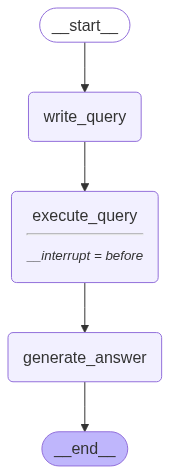

In [26]:
display(Image(graph.get_graph().draw_mermaid_png()))

In [28]:
for step in graph.stream(
    {"question": "How many employees are there?"},
    config,
    stream_mode="updates",
):
    print(step)

try:
    user_approval = input("Do you want to go to execute query? (yes/no): ")
except Exception:
    user_approval = "no"

if user_approval.lower() == "yes":
    for step in graph.stream(None, config, stream_mode="updates"):
        print(step)
else:
    print("Operation cancelled by user.")

{'write_query': {'query': 'SELECT COUNT(*) FROM employee LIMIT 10'}}
{'__interrupt__': ()}
{'execute_query': {'result': '[(8,)]'}}
{'generate_answer': {'answer': "Based on the provided information, I can determine that there are 8 employees in the database. The LIMIT clause is being used to limit the result set to a maximum of 10 rows, but since only 8 rows were returned, it appears that the LIMIT clause was not actually limiting the number of rows as intended.\n\nIt's worth noting that using LIMIT with SELECT COUNT(*) can be counterintuitive, and the correct approach would typically be to use the COUNT function on its own. If the intention is to retrieve a limited count of employees, it might be better to rephrase the query to something like:\n\nSELECT MIN(e.id) FROM employee e LIMIT 10"}}


## Agents

https://langchain-ai.github.io/langgraph/tutorials/sql-agent/?_gl=1*iuwmrt*_ga*MTM1ODM1Njc2NC4xNzQ5NDg1ODQ5*_ga_47WX3HKKY2*czE3NDk2MzYzNzgkbzMkZzEkdDE3NDk2Mzk4ODYkajYwJGwwJGgw#configure-the-database

Although their behavior is less predictable than the above "chain", they feature some advantages:

- They can query the database as many times as needed to answer the user question.
- They can recover from errors by running a generated query, catching the traceback and regenerating it correctly.
- They can answer questions based on the databases' schema as well as on the databases' content (like describing a specific table).

### Tools for database interactions 

langchain-community implements some built-in tools for interacting with our SQLDatabase, including tools for listing tables, reading table schemas, and checking and running queries:

In [1]:
from langchain.chat_models import init_chat_model


llm = init_chat_model(
    model="llama3.2",
    model_provider="ollama"
)

In [2]:
from langchain_community.utilities import SQLDatabase

db = SQLDatabase.from_uri("sqlite:///Chinook.db")

print(f"Dialect: {db.dialect}")
print(f"Available tables: {db.get_usable_table_names()}")
print(f'Sample output: {db.run("SELECT * FROM Artist LIMIT 5;")}')

Dialect: sqlite
Available tables: ['album', 'artist', 'customer', 'employee', 'invoice']
Sample output: [('1', 'AC/DC'), ('2', 'Accept'), ('3', 'Aerosmith'), ('4', 'Alanis Morissette'), ('5', 'Alice In Chains')]


In [3]:
from langchain_community.agent_toolkits import SQLDatabaseToolkit

toolkit = SQLDatabaseToolkit(db=db, llm=llm)

tools = toolkit.get_tools()

for tool in tools:
    print(f"{tool.name}: {tool.description}\n")

sql_db_query: Input to this tool is a detailed and correct SQL query, output is a result from the database. If the query is not correct, an error message will be returned. If an error is returned, rewrite the query, check the query, and try again. If you encounter an issue with Unknown column 'xxxx' in 'field list', use sql_db_schema to query the correct table fields.

sql_db_schema: Input to this tool is a comma-separated list of tables, output is the schema and sample rows for those tables. Be sure that the tables actually exist by calling sql_db_list_tables first! Example Input: table1, table2, table3

sql_db_list_tables: Input is an empty string, output is a comma-separated list of tables in the database.

sql_db_query_checker: Use this tool to double check if your query is correct before executing it. Always use this tool before executing a query with sql_db_query!



In [4]:
from langgraph.prebuilt import create_react_agent

system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

You MUST double check your query before executing it. If you get an error while
executing a query, rewrite the query and try again.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the
database.

To start you should ALWAYS look at the tables in the database to see what you
can query. Do NOT skip this step.

Then you should query the schema of the most relevant tables.
""".format(
    dialect=db.dialect,
    top_k=5,
)

agent = create_react_agent(
    llm,
    tools,
    prompt=system_prompt,
)

In [5]:
question = "Which sales agent made the most in sales in 2008?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which sales agent made the most in sales in 2008?
================================== Ai Message ==================================
Tool Calls:
  sql_db_query_checker (fde0bec5-846a-4cba-8ab5-9ad18e01066e)
 Call ID: fde0bec5-846a-4cba-8ab5-9ad18e01066e
  Args:
    query: SELECT sales_agent, SUM(sales) FROM sales_data WHERE year = 2008 GROUP BY sales_agent ORDER BY SUM(sales) DESC LIMIT 1
================================= Tool Message =================================
Name: sql_db_query_checker

SELECT sales_agent, SUM(sales) FROM sales_data WHERE year = 2008 GROUP BY sales_agent ORDER BY SUM(sales) DESC LIMIT 1
================================== Ai Message ==================================

<|python_tag|>import sqlite3

# Connect to the SQLite database
conn = sqlite3.connect('sales.db')
cursor = conn.cursor()

# Query the database for the top sales agent in 2008
query = "SELECT sales_agent, SUM(sales) FRO

In [6]:
question = "Hello, how are you?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Hello, how are you?
================================== Ai Message ==================================
Tool Calls:
  sql_db_list_tables (6aa9ac7b-0671-4e3f-8444-4719f5b35731)
 Call ID: 6aa9ac7b-0671-4e3f-8444-4719f5b35731
  Args:
    tool_input:
================================= Tool Message =================================
Name: sql_db_list_tables

album, artist, customer, employee, invoice
================================== Ai Message ==================================
Tool Calls:
  sql_db_schema_artists (a7df91ec-e1cd-4e7b-b0b8-6014b0018421)
 Call ID: a7df91ec-e1cd-4e7b-b0b8-6014b0018421
  Args:
    db: sqlite
================================= Tool Message =================================
Name: sql_db_schema_artists

Error: sql_db_schema_artists is not a valid tool, try one of [sql_db_query, sql_db_schema, sql_db_list_tables, sql_db_query_checker].
================================== Ai Message ========

## ReAct-agent setup

In [7]:
from typing import Literal
from langchain_core.messages import AIMessage
from langchain_core.runnables import RunnableConfig
from langgraph.graph import END, START, MessagesState, StateGraph
from langgraph.prebuilt import ToolNode


get_schema_tool = next(tool for tool in tools if tool.name == "sql_db_schema")
get_schema_node = ToolNode([get_schema_tool], name="get_schema")

run_query_tool = next(tool for tool in tools if tool.name == "sql_db_query")
run_query_node = ToolNode([run_query_tool], name="run_query")


# Example: create a predetermined tool call
def list_tables(state: MessagesState):
    tool_call = {
        "name": "sql_db_list_tables",
        "args": {},
        "id": "abc123",
        "type": "tool_call",
    }
    tool_call_message = AIMessage(content="", tool_calls=[tool_call])

    list_tables_tool = next(tool for tool in tools if tool.name == "sql_db_list_tables")
    tool_message = list_tables_tool.invoke(tool_call)
    response = AIMessage(f"Available tables: {tool_message.content}")

    return {"messages": [tool_call_message, tool_message, response]}


# Example: force a model to create a tool call
def call_get_schema(state: MessagesState):
    # Note that LangChain enforces that all models accept `tool_choice="any"`
    # as well as `tool_choice=<string name of tool>`.
    llm_with_tools = llm.bind_tools([get_schema_tool], tool_choice="any")
    response = llm_with_tools.invoke(state["messages"])

    return {"messages": [response]}


generate_query_system_prompt = """
You are an agent designed to interact with a SQL database.
Given an input question, create a syntactically correct {dialect} query to run,
then look at the results of the query and return the answer. Unless the user
specifies a specific number of examples they wish to obtain, always limit your
query to at most {top_k} results.

You can order the results by a relevant column to return the most interesting
examples in the database. Never query for all the columns from a specific table,
only ask for the relevant columns given the question.

DO NOT make any DML statements (INSERT, UPDATE, DELETE, DROP etc.) to the database.
""".format(
    dialect=db.dialect,
    top_k=5,
)


def generate_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": generate_query_system_prompt,
    }
    # We do not force a tool call here, to allow the model to
    # respond naturally when it obtains the solution.
    llm_with_tools = llm.bind_tools([run_query_tool])
    response = llm_with_tools.invoke([system_message] + state["messages"])

    return {"messages": [response]}


check_query_system_prompt = """
You are a SQL expert with a strong attention to detail.
Double check the {dialect} query for common mistakes, including:
- Using NOT IN with NULL values
- Using UNION when UNION ALL should have been used
- Using BETWEEN for exclusive ranges
- Data type mismatch in predicates
- Properly quoting identifiers
- Using the correct number of arguments for functions
- Casting to the correct data type
- Using the proper columns for joins

If there are any of the above mistakes, rewrite the query. If there are no mistakes,
just reproduce the original query.

You will call the appropriate tool to execute the query after running this check.
""".format(dialect=db.dialect)


def check_query(state: MessagesState):
    system_message = {
        "role": "system",
        "content": check_query_system_prompt,
    }

    # Generate an artificial user message to check
    tool_call = state["messages"][-1].tool_calls[0]
    user_message = {"role": "user", "content": tool_call["args"]["query"]}
    llm_with_tools = llm.bind_tools([run_query_tool], tool_choice="any")
    response = llm_with_tools.invoke([system_message, user_message])
    response.id = state["messages"][-1].id

    return {"messages": [response]}

In [8]:
def should_continue(state: MessagesState) -> Literal[END, "check_query"]:
    messages = state["messages"]
    last_message = messages[-1]
    if not last_message.tool_calls:
        return END
    else:
        return "check_query"


builder = StateGraph(MessagesState)
builder.add_node(list_tables)
builder.add_node(call_get_schema)
builder.add_node(get_schema_node, "get_schema")
builder.add_node(generate_query)
builder.add_node(check_query)
builder.add_node(run_query_node, "run_query")

builder.add_edge(START, "list_tables")
builder.add_edge("list_tables", "call_get_schema")
builder.add_edge("call_get_schema", "get_schema")
builder.add_edge("get_schema", "generate_query")
builder.add_conditional_edges(
    "generate_query",
    should_continue,
)
builder.add_edge("check_query", "run_query")
builder.add_edge("run_query", "generate_query")

agent = builder.compile()

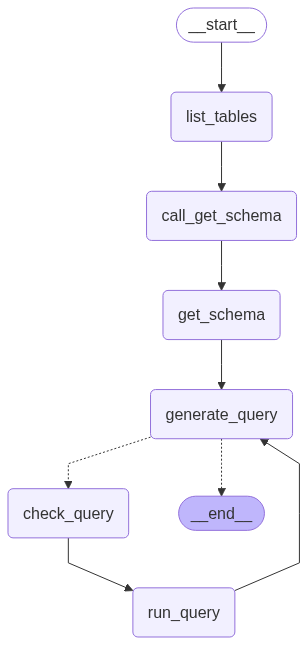

In [9]:
from IPython.display import Image, display
from langchain_core.runnables.graph import CurveStyle, MermaidDrawMethod, NodeStyles

display(Image(agent.get_graph().draw_mermaid_png()))

In [11]:
question = "Which sales agent made the most in sales in 2009?"

for step in agent.stream(
    {"messages": [{"role": "user", "content": question}]},
    stream_mode="values",
):
    step["messages"][-1].pretty_print()

================================ Human Message =================================

Which sales agent made the most in sales in 2009?
================================== Ai Message ==================================

Available tables: album, artist, customer, employee, invoice
================================== Ai Message ==================================

 

In 2009, I don't have the specific information on which sales agent made the most in sales. The tool output only lists available tables, but it does not contain data on individual sales agents or their performance metrics. If you need this information, I would recommend checking the sales database or contacting the relevant authorities for more detailed insights.
================================== Ai Message ==================================

 

In 2009, I don't have the specific information on which sales agent made the most in sales. The tool output only lists available tables, but it does not contain data on individual sales age

### Agent Model evaluation 

https://docs.smith.langchain.com/evaluation/how_to_guides/langgraph